## Case 1 - Using the provided nonlinear equation

Starting model training...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=140; total time=   0.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END max_depth=10, max_features=None, min_samples_leaf=2, min_s

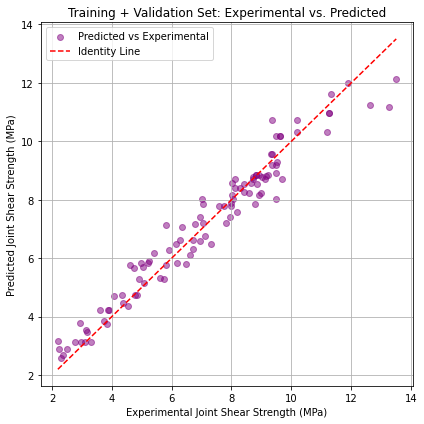

Number of data points plotted (Test Set): 27


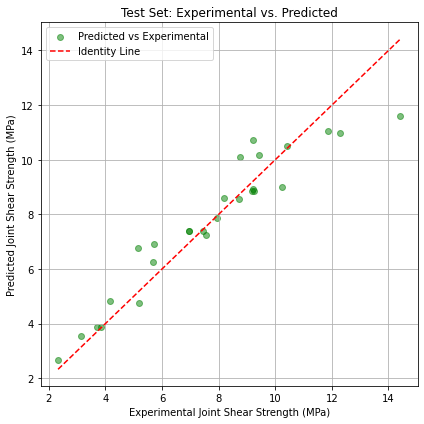

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_excel('../input_data/dataset.xlsx')
data.columns = data.columns.str.strip()

if 'gamma' in data.columns and 'jointtype' in data.columns:
    coefficients = {
        'Exterior': {'alpha': 0.25, 'beta': 0.75, 'gamma': 1.50, 
                    'C1': 0.30, 'C2': -1.10, 'C3': -0.20, 'C4': -0.70, 'C5': 2.00, 'C6': 0.50},
        'Interior': {'alpha': 0.00, 'beta': 1.00, 'gamma': 2.10, 
                    'C1': 0.30, 'C2': -1.10, 'C3': -0.20, 'C4': -0.70, 'C5': 2.00, 'C6': 0.50}
    }
    
    data['alpha'] = data['jointtype'].map(lambda jt: coefficients[jt]['alpha'])
    data['beta'] = data['jointtype'].map(lambda jt: coefficients[jt]['beta'])
    data['gamma'] = data['jointtype'].map(lambda jt: coefficients[jt]['gamma'])
    data['C1'] = coefficients['Exterior']['C1']  
    data['C2'] = coefficients['Exterior']['C2']
    data['C3'] = coefficients['Exterior']['C3']
    data['C4'] = coefficients['Exterior']['C4']
    data['C5'] = coefficients['Exterior']['C5']
    data['C6'] = coefficients['Exterior']['C6']

    term_1 = data['sigcc']
    Ag = data['bb'] * data['hb']  
    term_2 = 1 + (data['C1'] * data['n'] * data['fc'] / Ag)
    
    geometric_term = data['gamma'] * (data['hb'] * data['bb']) ** data['C2'] * (data['hc'] * data['bc']) ** data['C3'] * (data['bb'] * data['hc']) ** data['C4']
    reinforcement_term_1 = data['RI'] ** data['alpha']
    reinforcement_term_2 = data['C5'] * (data['rogross'] ** data['C6']) * (data['RI'] ** data['beta'])
    
    X_terms = pd.DataFrame({
        'term_1': term_1,
        'term_2': term_2,
        'geometric_term': geometric_term,
        'reinforcement_term_1': reinforcement_term_1,
        'reinforcement_term_2': reinforcement_term_2,
        'gamma': data['gamma']
    })

    y = data['vj']

    X_terms.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_terms.fillna(0, inplace=True)

    X_train, X_temp, y_train, y_temp = train_test_split(X_terms, y, test_size=0.4, random_state=50)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=50)

    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    param_grid = {
        'n_estimators': list(range(10, 201, 10)),
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    print("Starting model training...")
    rf_model = RandomForestRegressor(random_state=50)
    
    rf_random = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        n_iter=30,
        cv=5,
        random_state=50,
        n_jobs=-1,
        verbose=2,
        error_score='raise'
    )

    try:
        rf_random.fit(X_train_val, y_train_val)
        print("\nBest parameters found:", rf_random.best_params_)
        
        best_rf_model = rf_random.best_estimator_

        feature_importance = pd.DataFrame({
            'Feature': ['σcc', 'Axial Load Effect', 'Geometric Terms', 'RI Term 1', 'RI Term 2', 'Gamma'],
            'Importance': best_rf_model.feature_importances_
        })
        print("\nFeature Importance:")
        print(feature_importance.sort_values(by='Importance', ascending=False))

        y_val_pred = best_rf_model.predict(X_val)
        y_train_val_pred = best_rf_model.predict(X_train_val)
        y_test_pred = best_rf_model.predict(X_test)

        metrics = []
        for name, y_true, y_pred in [
            ('Validation', y_val, y_val_pred),
            ('Training + Validation', y_train_val, y_train_val_pred),
            ('Test', y_test, y_test_pred)
        ]:
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            r = np.corrcoef(y_true, y_pred)[0, 1]
            metrics.append({
                'Dataset': name,
                'R': r,
                'R²': r2_score(y_true, y_pred),
                'MSE': mse,
                'RMSE': rmse,
                'Mean Absolute Percentage Error (%)': np.mean(np.abs((y_true - y_pred) / y_true) * 100)
            })

        comparison_df = pd.DataFrame(metrics)
        print("\nModel Performance Metrics:")
        print(comparison_df.round(4))

        def create_prediction_plot(y_true, y_pred, title, color, filename):
            plt.figure(figsize=(6, 6))
            plt.scatter(y_true, y_pred, color=color, alpha=0.5, label='Predicted vs Experimental')
            plt.plot([y_true.min(), y_true.max()], 
                    [y_true.min(), y_true.max()], 
                    'r--', 
                    label='Identity Line')
            plt.xlabel('Experimental Joint Shear Strength (MPa)')
            plt.ylabel('Predicted Joint Shear Strength (MPa)')
            plt.title(title)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            print(f"Number of data points plotted ({title.split(':')[0]}): {len(y_true)}")
            plt.savefig(filename, dpi=1000, bbox_inches='tight')
            plt.show()

        create_prediction_plot(y_train_val, y_train_val_pred, 
                             'Training + Validation Set: Experimental vs. Predicted', 
                             'purple', '../random_forest_results/training_validation_plot_case1.png')
        
        create_prediction_plot(y_test, y_test_pred, 
                             'Test Set: Experimental vs. Predicted', 
                             'green', '../random_forest_results/test_set_plot_case1.png')

    except Exception as e:
        print(f"An error occurred during model training: {str(e)}")
        print("Please check your data and parameters")


Features ranked by average importance:
σcc: 0.6781
RI 1 & 2: 0.1276
n: 0.0860
Geom: 0.0614
Gamma: 0.0469
γ: 0.0000


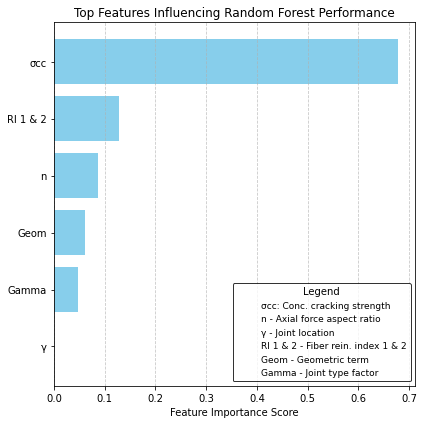


Feature importance stability metrics:
σcc:
  Mean: 0.6781
  Std Dev: 0.0051
  Coefficient of Variation: 0.76%
n:
  Mean: 0.0860
  Std Dev: 0.0038
  Coefficient of Variation: 4.47%
γ:
  Mean: 0.0000
  Std Dev: 0.0000
  Coefficient of Variation: 0.00%
RI 1 & 2:
  Mean: 0.1276
  Std Dev: 0.0022
  Coefficient of Variation: 1.75%
Geom:
  Mean: 0.0614
  Std Dev: 0.0064
  Coefficient of Variation: 10.43%
Gamma:
  Mean: 0.0469
  Std Dev: 0.0020
  Coefficient of Variation: 4.31%


In [7]:
import matplotlib.patches as mpatches

feature_names = [
    "σcc",
    "n",
    "γ",
    "RI 1 & 2",
    "Geom",
    "Gamma"  
]

legends = [
    "σcc: Conc. cracking strength",
    "n - Axial force aspect ratio",
    "γ - Joint location",
    "RI 1 & 2 - Fiber rein. index 1 & 2",
    "Geom - Geometric term",
    "Gamma - Joint type factor"
]

n_trees_range = range(10, 210, 10)  
feature_importances = []

for n_trees in n_trees_range:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=50)
    rf.fit(X_train_val, y_train_val)
    feature_importances.append(rf.feature_importances_)

feature_importances = np.array(feature_importances)
avg_feature_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(avg_feature_importances)[::-1]
sorted_features = [(feature_names[i], avg_feature_importances[i]) for i in sorted_indices]

print("\nFeatures ranked by average importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(6, 6))
features, importances = zip(*sorted_features)

plt.barh(features, importances, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Top Features Influencing Random Forest Performance")
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)  

patches = [mpatches.Patch(color='white', label=leg) for leg in legends]

plt.legend(
   handles=patches,
   loc='lower right',  
   frameon=True,
   edgecolor='black',
   title="Legend",
   fontsize=9
)

plt.tight_layout() 
plt.savefig('../random_forest_results/feature_importance_analysis_case1.png', dpi=1000, bbox_inches='tight')
plt.show()

print("\nFeature importance stability metrics:")
for i, feature in enumerate(feature_names):
    mean_importance = np.mean(feature_importances[:, i])
    std_importance = np.std(feature_importances[:, i])
    cv = (std_importance / mean_importance) * 100 if mean_importance > 0 else 0
    print(f"{feature}:")
    print(f"  Mean: {mean_importance:.4f}")
    print(f"  Std Dev: {std_importance:.4f}")
    print(f"  Coefficient of Variation: {cv:.2f}%")


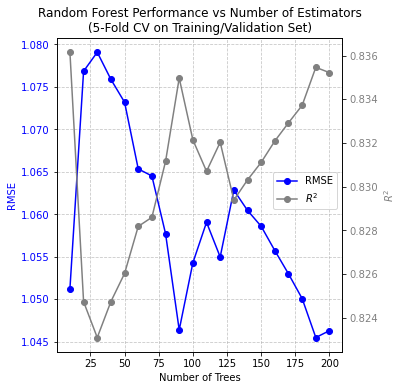


Optimal number of trees based on RMSE: 190
Minimum RMSE: 1.0455

Optimal number of trees based on R²: 10
Maximum R²: 0.8362


In [8]:
from sklearn.model_selection import cross_val_score

num_trees = np.arange(10, 210, 10) 
rmse_scores = []
r2_scores = []

for n_trees in num_trees:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=50)
    mse_scores = cross_val_score(rf, X_train_val, y_train_val, 
                                scoring='neg_mean_squared_error', 
                                cv=5)
    r2 = cross_val_score(rf, X_train_val, y_train_val, 
                         scoring='r2', 
                         cv=5)
    
    rmse_scores.append(np.sqrt(-np.mean(mse_scores)))
    r2_scores.append(np.mean(r2))

fig, ax1 = plt.subplots(figsize=(6, 6))

ax1.plot(num_trees, rmse_scores, marker='o', linestyle='-', 
         label='RMSE', color='blue')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('RMSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(num_trees, r2_scores, marker='o', linestyle='-', 
         label='$R^2$', color='gray')
ax2.set_ylabel('$R^2$', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

ax1.grid(True, linestyle='--', alpha=0.7)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, 
          loc='center right', bbox_to_anchor=(0.8, 0.5))
plt.title('Random Forest Performance vs Number of Estimators\n(5-Fold CV on Training/Validation Set)')
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])
plt.savefig('../random_forest_results/rf_performance_metrics_case1.png', dpi=1000, bbox_inches='tight')
plt.show()


optimal_trees_rmse = num_trees[np.argmin(rmse_scores)]
optimal_trees_r2 = num_trees[np.argmax(r2_scores)]
print(f"\nOptimal number of trees based on RMSE: {optimal_trees_rmse}")
print(f"Minimum RMSE: {min(rmse_scores):.4f}")
print(f"\nOptimal number of trees based on R²: {optimal_trees_r2}")
print(f"Maximum R²: {max(r2_scores):.4f}")